In [1]:
import os
import glob
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/pscratch/sd/q/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import *; from tools.BLtools import *; from tools.e5tools import *
from tropicalOrographicRegions.mountainUtils import tilted_rect

from scipy.stats import linregress
#xr.set_options(display_style='text') 

%load_ext autoreload
%autoreload 2

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
def sel_box_months(var,box,months,lon='longitude',lat='latitude',lat_increase=False):
    window = sel_box(var,box,lon,lat,lat_increase)
    window=sel_months(window,months)
    return window


def reorder(da):
    da.coords['longitude'] = da.coords['longitude'] % 360
    da = da.sortby(da.longitude)
    return da.reindex(latitude=list(reversed(da.latitude)))
 

In [3]:
orogm = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
lsm = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
box = [60,150,0,30]
months = [6,7,8]
# Ghats mask
ghats_tilted_rect = [ 75  ,   9  ,  71.5, 20   ,2]

In [4]:
aphrodite_path = "/global/cfs/projectdirs/m3310/qnicolas/APHRODITE/"
aphrodite_1 = xr.open_dataset(aphrodite_path+"APHRO_MA_025deg_V1101.1951-2007.monthly.nc")
aphrodite_2 = xr.open_dataset(aphrodite_path+"APHRO_MA_025deg_V1101_EXR1.2007-2015.monthly.nc")
aphrodite_monthly = reorder(xr.concat((aphrodite_1.precip.sel(time=(aphrodite_1['time.year']<2007)),\
                                       aphrodite_2.precip.rename({'lat':'latitude','lon':'longitude'})),\
                                      dim='time'))

In [5]:
imd_monthly = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/IMD/IMD_rain.monthly.1901-2022.nc").RAINFALL

In [6]:
class PrecipDataset :
    def __init__(self, data, name):
        self.name=name
        self.precip=data
        self.resolution = ("%.3f"%float(data.longitude[1]-data.longitude[0])).rstrip('0')+"°"
        self.time_range = (pd.to_datetime(data.time.min().values).strftime("%Y-%m"),pd.to_datetime(data.time.max().values).strftime("%Y-%m"))
        

In [7]:
APHRODITE = PrecipDataset(aphrodite_monthly,'APHRODITE')
IMD  = PrecipDataset(imd_monthly,'IMD')
datasets = (APHRODITE, IMD )

In [8]:
%%time
for dataset in datasets:
    dataset.precip_jja_yearly = sel_box_months(dataset.precip,box = box, months=months).groupby('time.year').mean().load()
    dataset.jja_time_range = (int(dataset.precip_jja_yearly.year.min().values),int(dataset.precip_jja_yearly.year.max().values))
    dataset.precip_ond_yearly = sel_box_months(dataset.precip,box = box, months=[10,11,12]).groupby('time.year').mean().load()
    dataset.ond_time_range = (int(dataset.precip_ond_yearly.year.min().values),int(dataset.precip_ond_yearly.year.max().values))
          

CPU times: user 285 ms, sys: 34.9 ms, total: 320 ms
Wall time: 564 ms


In [9]:
for dataset in datasets:
    dataset.lsm = lsm.interp_like(dataset.precip_jja_yearly)>0.1
    dataset.ghats_mask = sel_box(dataset.lsm*tilted_rect(dataset.lsm,*ghats_tilted_rect),box)

In [10]:
data_info = {
    "name": [dataset.name for dataset in datasets],
    "resolution": [dataset.resolution for dataset in datasets],
    "time_range": [dataset.time_range for dataset in datasets],
    "jja_time_range": [dataset.jja_time_range for dataset in datasets],
}
pd.DataFrame(data_info)

,name,resolution,time_range,jja_time_range
0,APHRODITE,0.25°,"(1951-01, 2015-12)","(1951, 2015)"
1,IMD,0.25°,"(1901-01, 2022-12)","(1901, 2022)"


# Theory

In [28]:
from orographicConvectionTheory.orographicConvectionTheory import k_vector,m_exponent,linear_precip_theory,topographic_profile

from matplotlib.patches import Polygon

In [29]:
def linear_zeta(h,N,U,x,z):
    k=k_vector(len(x),x[1]-x[0])
    zetahat = np.fft.fft(h)[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:])
    zeta=xr.DataArray(np.real(np.fft.ifft(zetahat,axis=0)),coords={'x':x,'z':z},dims={'x':x,'z':z})
    return zeta

In [30]:
xx,hx = topographic_profile('cos',A=500)
zz = np.arange(0.,11e3,100.)
zeta_10 = linear_zeta(hx,0.01,10.,xx,zz)
zeta_11 = linear_zeta(hx,0.01,12.,xx,zz)

In [31]:
Pp_10 = linear_precip_theory(xx,hx,10,P0=50.,tauT=7.5,tauq=27.5) - 50.
Pp_12 = linear_precip_theory(xx,hx,12,P0=50.,tauT=7.5,tauq=27.5) - 50.
Pd_10 = linear_precip_theory(xx,hx,10,P0=50.,tauT=7.5,tauq=27.5,switch=1e-4) - 50.
Pd_12 = linear_precip_theory(xx,hx,12,P0=50.,tauT=7.5,tauq=27.5,switch=1e-4) - 50.

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

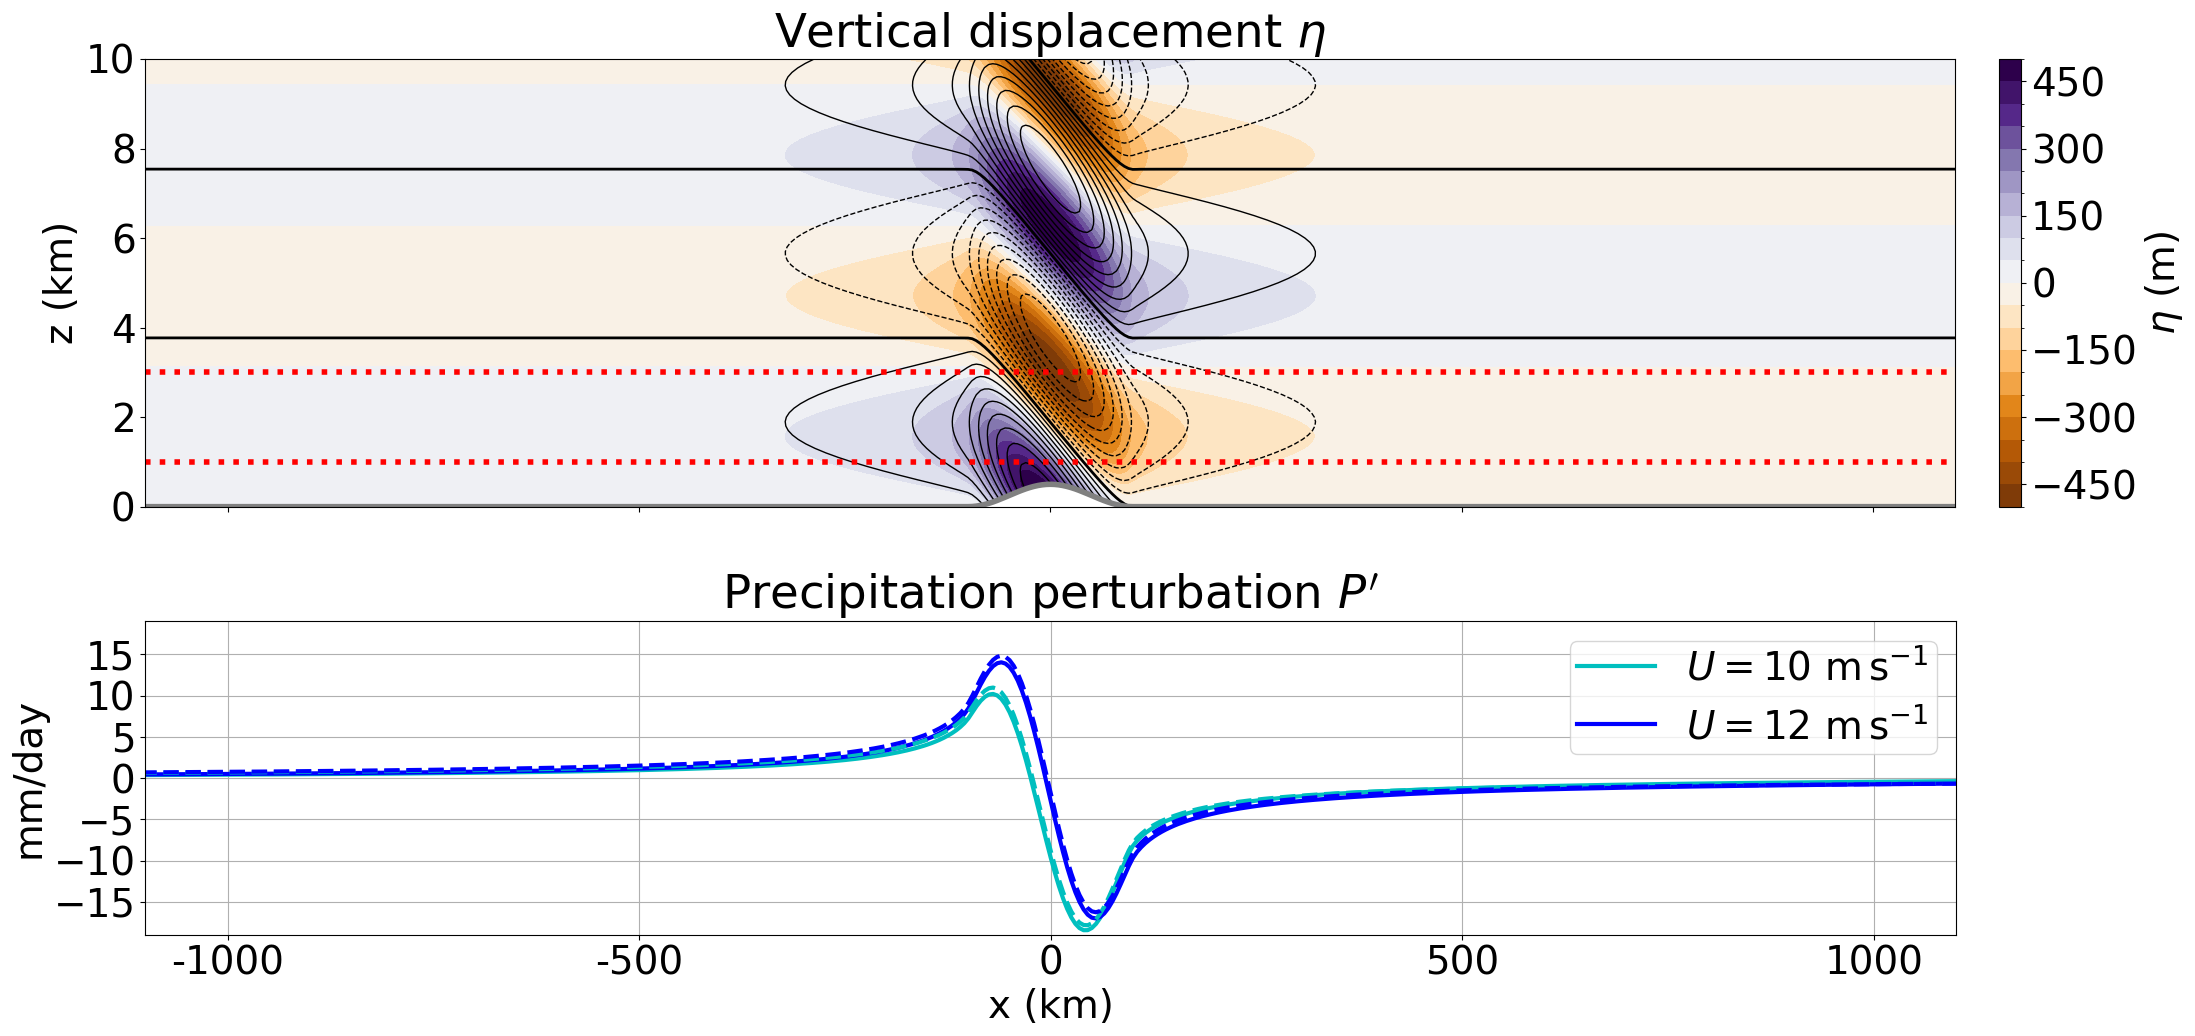

In [41]:
matplotlib.rcParams.update({'font.size': 28})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(24,11),height_ratios=(1,0.7))


# Shadings & contours
levs = np.linspace(-500,500,21)
n=len(levs)

zeta_10.plot.contourf(ax=ax,y='z',levels=levs,cmap = plt.cm.PuOr,cbar_kwargs={'label':r"$\eta$ (m)","pad":0.02})
(zeta_11).plot.contour(ax=ax,y='z',levels=levs,colors=['k']*n,linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))

# fill white space
ax.fill_between(xx,0*xx,hx,color='w',zorder=2)
ax.plot(xx,hx,color='gray',linewidth=4)

ax.axhline(1000.,color='r',linestyle=':',linewidth=4)
ax.axhline(3000.,color='r',linestyle=':',linewidth=4)

ax.set_xlim(-1100e3,1100e3)
ticks = np.arange(-1000,1100,500)
ax.set_xticks(list(ticks*1e3))
ax.set_xticklabels('')
ax.set_xlabel('')

ax.set_ylim(0,10000)
ax.set_yticks(np.arange(0,11,2)*1e3)
ax.set_yticklabels(np.arange(0,11,2))
ax.set_ylabel('z (km)')

ax2.plot(xx,Pp_10,color='c',linewidth=3,label=r"$U=$10 m$\,$s$^{-1}$")
ax2.plot(xx,Pp_12,color='b',linewidth=3,label=r"$U=$12 m$\,$s$^{-1}$")
ax2.plot(xx,Pd_10,color='c',linewidth=3,linestyle='--')
ax2.plot(xx,Pd_12,color='b',linewidth=3,linestyle='--')
ax2.set_ylim(-19,19)
ax2.set_ylabel("mm/day")
ax2.set_xlim(-1100e3,1100e3)
ax2.set_xticks(list(ticks*1e3))
ax2.set_xticklabels(ticks)
ax2.set_xlabel('x (km)')

yticks=np.arange(-15,16,5)
ax2.set_yticks(yticks)
ax2.legend(loc=1,borderpad=0.2,fontsize=28)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size=2.7, pad=1.,axes_class=plt.Axes)
cax2.remove()
ax2.grid()


ax.set_title(r"Vertical displacement $\eta$")
ax2.set_title(r"Precipitation perturbation $P'$")

fig.tight_layout()
#rect1 = matplotlib.patches.Rectangle((0,0), 200000, 1000, color='white',zorder=5)

#ax.add_patch(rect1)

In [146]:
Pp_10 = linear_precip_theory(xx,hx,10,P0=50.,tauT=3.,tauq=11.) - 50.
Pp_12 = linear_precip_theory(xx,hx,12,P0=50.,tauT=3.,tauq=11.) - 50.
Pd_10 = linear_precip_theory(xx,hx,10,P0=50.,tauT=3.,tauq=11.,switch=1e-4) - 50.
Pd_12 = linear_precip_theory(xx,hx,12,P0=50.,tauT=3.,tauq=11.,switch=1e-4) - 50.

In [149]:
(np.max(Pp_12)/np.max(Pp_10)-1)*100

36.769598866525314

In [142]:
(np.max(Pd_12)/np.max(Pd_10)-1)*100

35.17703651563808

# Simulations - T' and P'

In [11]:
from tools.wrfHrTools import Simulation,change_coords_pl

In [12]:
class SimulationCustom2(Simulation):
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        self.RAINNC_MEAN = xr.open_dataarray(self.path+'wrf.RAINNC.ALLMEAN.nc')
        RAINNC_DAILY = xr.open_zarr(self.path+'wrf.RAINNC.1h.ALL_CONCAT.zarr').RAINNC_MMDY[1200:].mean('south_north').coarsen(Time=24).mean()
        self.RAINNC_STERR = 2 * RAINNC_DAILY.std('Time').load() / np.sqrt(len(RAINNC_DAILY.Time))
        
        self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
        self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.ALLMEAN.nc')
        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')

W10S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000',inp=True)
W12S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/'          ,1635,3,'1970010100-1971010400',inp=True)   

In [13]:
W10S300.color='c'
W12S300.color='blue'

W10S300.label=r'$U = 10$ m$\,$s$^{-1}$'
W12S300.label=r'$U = 12$ m$\,$s$^{-1}$'

In [84]:
def prime(ds,reverse=False):
    if reverse:
        return ds - ds.sel(distance_from_mtn=slice(-4000,-2500)).mean('distance_from_mtn')
    else:
        return ds - ds.sel(distance_from_mtn=slice(-2500,-4000)).mean('distance_from_mtn')

In [15]:
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile
xx,hx=topographic_profile('cos',A=500.)

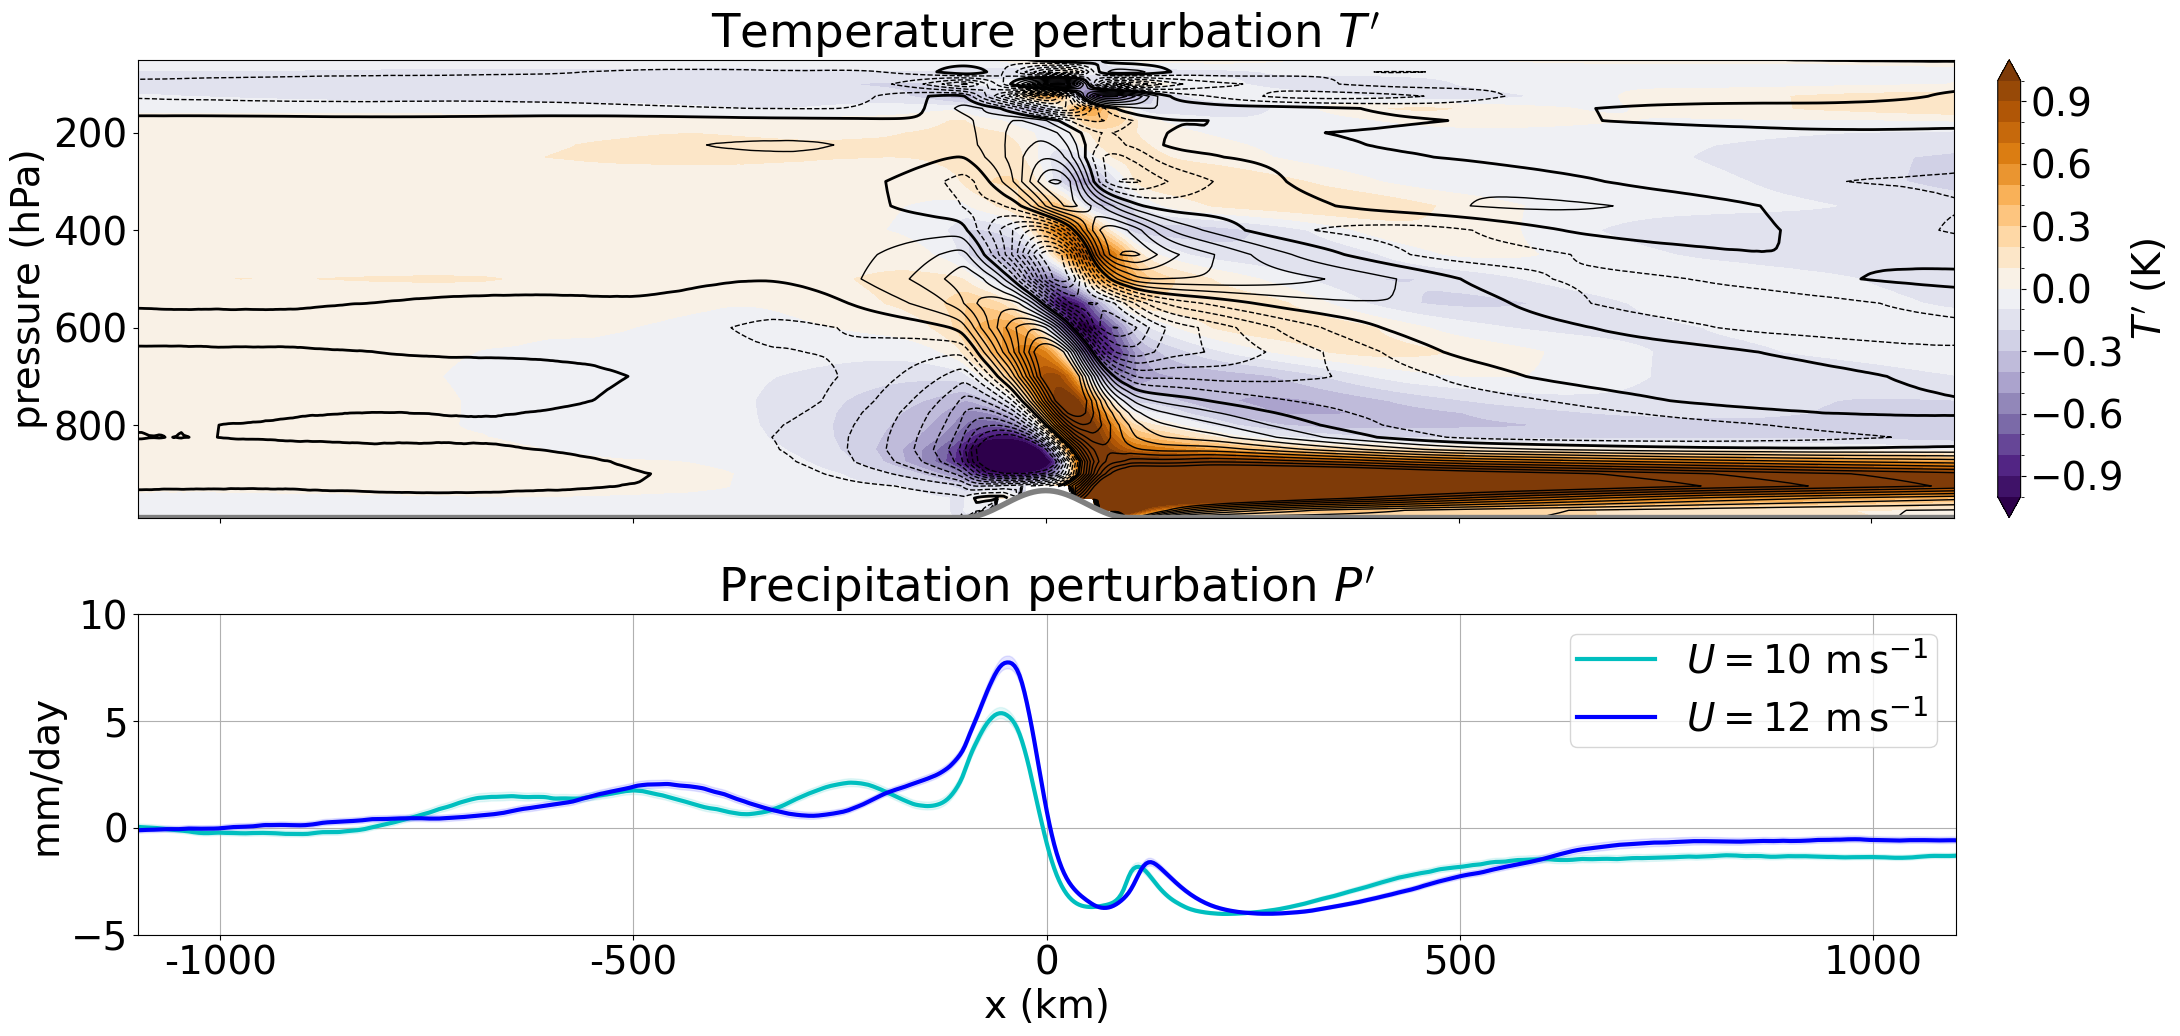

In [43]:
matplotlib.rcParams.update({'font.size': 28})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(24,11),height_ratios=(1,0.7))


# Shadings & contours
levs = np.linspace(-1,1,21)
n=len(levs)

prime(W10S300.T_PL_MEAN).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=levs,cmap=plt.cm.PuOr_r,extend='both',cbar_kwargs={'label':r"$T'$ (K)","pad":0.02})
prime(W12S300.T_PL_MEAN).plot.contour (ax=ax,y='pressure',yincrease=False,levels=levs,colors='k',linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))
#zeta_10.plot.contourf(ax=ax,y='z',levels=levs,cmap = plt.cm.PuOr_r,cbar_kwargs={'label':r"$\eta$ (m)","pad":0.02})
#(zeta_11).plot.contour(ax=ax,y='z',levels=levs,colors=['k']*n,linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))

# fill white space
ax.fill_between(xx/1e3,990*xx**0,990 - hx/9,color='w',zorder=2)
ax.plot(xx/1e3,990 - hx/9,color='gray',linewidth=4)

ax.set_xlim(-1100,1100)
ticks = np.arange(-1000,1100,500)
ax.set_xticks(list(ticks))
ax.set_xticklabels('')
ax.set_xlabel('')

ax.set_ylabel('pressure (hPa)')




for Sim in (W10S300,W12S300):
    prime(Sim.RAINNC_MEAN).plot(ax=ax2,color=Sim.color,label=Sim.label,linewidth=3)
    ax2.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)

ax2.set_ylim(-5,10)
ax2.set_ylabel("mm/day")
ax2.set_xlim(-1100,1100)
ax2.set_xticks(list(ticks))
ax2.set_xticklabels(ticks)
ax2.set_xlabel('x (km)')

#yticks=np.arange(-40,41,20)
#ax2.set_yticks(yticks)
ax2.legend(loc=1,borderpad=0.2,fontsize=28)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size=2.7, pad=1.,axes_class=plt.Axes)
cax2.remove()
ax2.grid()

ax.set_title(r"Temperature perturbation $T'$")
ax2.set_title(r"Precipitation perturbation $P'$")

fig.tight_layout()
#rect1 = matplotlib.patches.Rectangle((0,0), 200000, 1000, color='white',zorder=5)

#ax.add_patch(rect1)

# Simulations - B_L stuff

In [16]:
for Sim in W10S300 , W12S300:
    Sim.PSFC_MEAN = xr.open_zarr(Sim.path + "wrf.PSFC_INTERP.1h.%s.zarr"%Sim.suffix2).PSFC[-480:].mean(('Time','south_north')).load()
    Sim.THETAE_MEAN = xr.open_dataarray(Sim.path + "wrf.THETAE.ALLMEAN.nc")

In [17]:
def averageB(ds,psfc,ptop=850):
    ds = ds.bfill(dim='pressure')
    p1 = 990;p2=ptop
    part1 = -ds.sel(pressure=slice(p1,p2)).integrate('pressure')
    part2 = ds.sel(pressure=p1)*(psfc-990)
    return ((part1+part2)/(psfc-ptop))
def averageL(ds,p1 = 850,p2 = 500):
    return (-ds.sel(pressure=slice(p1,p2)).integrate('pressure')/(p1-p2))

In [18]:
W10S300.color2='gold'
W12S300.color2='red'

W10S300.color3='lime'
W12S300.color3='green'

(-1100.0, 1100.0)

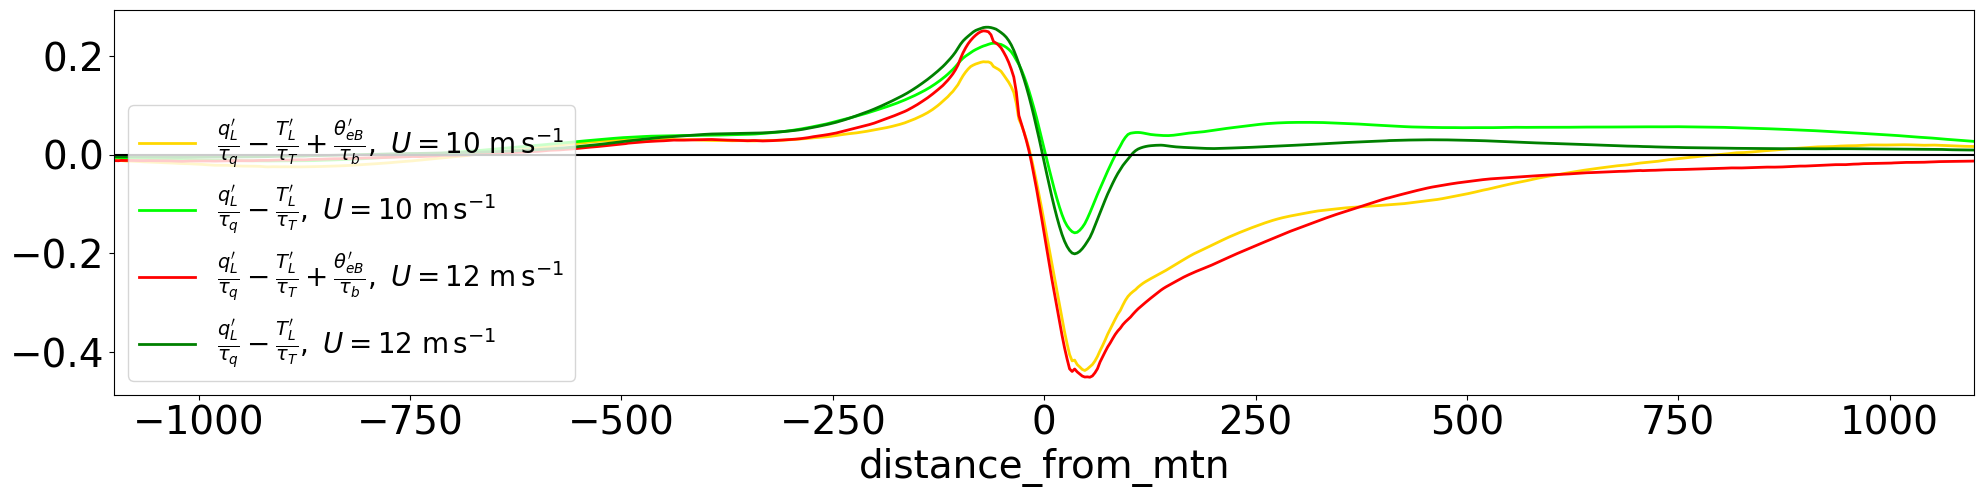

In [19]:
matplotlib.rcParams.update({'font.size': 28})
fig,ax=plt.subplots(1,1,figsize=(24,5))


for Sim in W10S300 , W12S300:
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e3
    
    #eB = averageB(Sim.T_PL_MEAN,Sim.PSFC_MEAN/100,900) + 2.5e3 * averageB(Sim.Q_PL_MEAN,Sim.PSFC_MEAN/100,900)
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    (- prime(TL) / 3 + prime(qL)/11 + prime(eB)/11).plot(ax=ax,color = Sim.color2,linewidth=2, label=r"$\frac{q_L'}{\tau_q}-\frac{T_L'}{\tau_T}+\frac{\theta_{eB}'}{\tau_b},$ " + Sim.label)
    (- prime(TL) / 3 + prime(qL)/11               ).plot(ax=ax,color = Sim.color3,linewidth=2, label=r"$\frac{q_L'}{\tau_q}-\frac{T_L'}{\tau_T},$ " + Sim.label)
ax.axhline(0.,color='k')
ax.legend(fontsize=20,loc=3)
ax.set_xlim(-1100,1100)

In [49]:
measures = [[],[],[]]
for Sim in W10S300 , W12S300:
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e3
    
    #eB = averageB(Sim.T_PL_MEAN,Sim.PSFC_MEAN/100,900) + 2.5e3 * averageB(Sim.Q_PL_MEAN,Sim.PSFC_MEAN/100,900)
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    measures[0].append(prime(Sim.RAINNC_MEAN))
    measures[1].append(- prime(TL) / 3 + prime(qL)/11 + prime(eB)/11)
    measures[2].append(- prime(TL) / 3 + prime(qL)/11 )

for i in range(len(measures)):
    change = (measures[i][1].max()/measures[i][0].max() - 1) *100/2
    print( "%.2f %%/(m/s)"%(change) )
    

22.14 %/(m/s)
16.64 %/(m/s)
7.15 %/(m/s)


## Aside: changes with warming

In [14]:
W10S296   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/',1635,3,'1970010100-1970090900',inp=True)

In [20]:
W10S296.color='paleturquoise'
W10S296.color2='wheat'
W10S296.color3='greenyellow'

W10S300.label=r'SST = 300K'
W10S296.label=r'SST = 296K'

In [16]:
Sim = W10S296
Sim.PSFC_MEAN = xr.open_zarr(Sim.path + "wrf.PSFC_INTERP.1h.%s.zarr"%Sim.suffix2).PSFC[-480:].mean(('Time','south_north')).load()
Sim.THETAE_MEAN = xr.open_dataarray(Sim.path + "wrf.THETAE.ALLMEAN.nc")

(-1100.0, 1100.0)

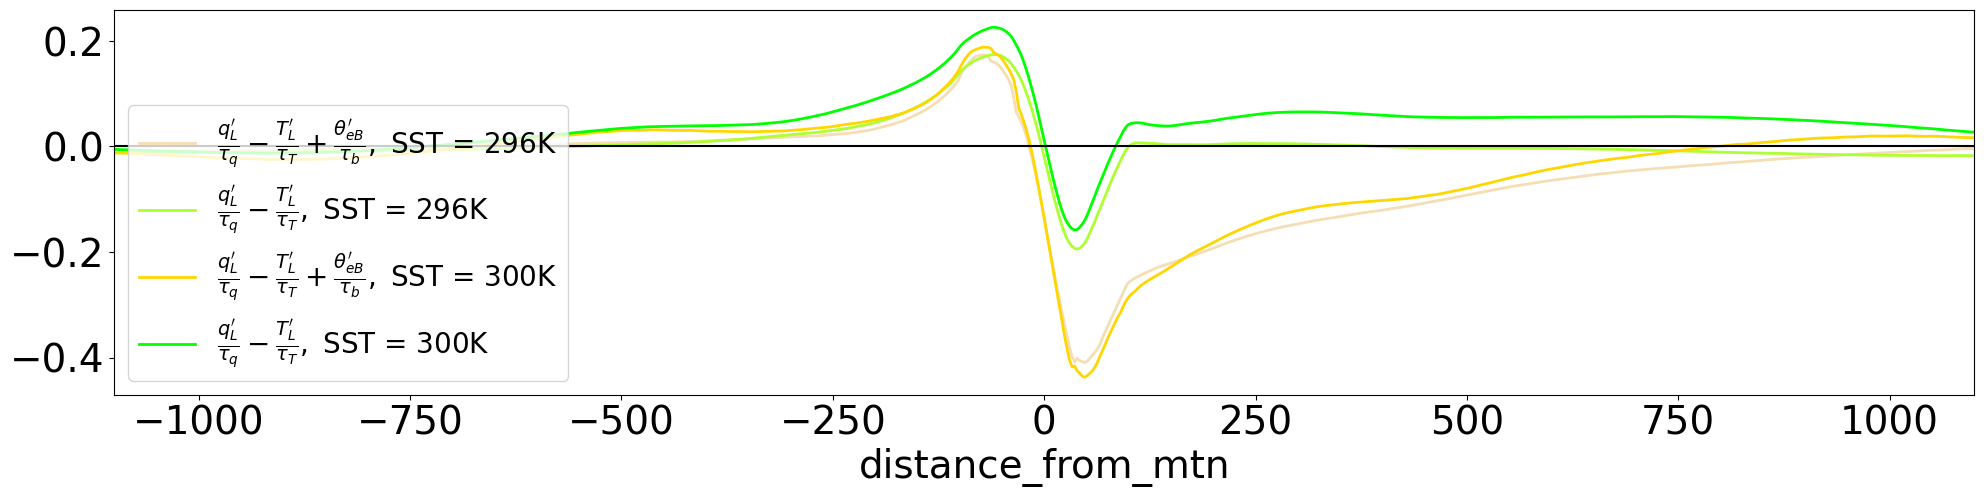

In [27]:
matplotlib.rcParams.update({'font.size': 28})
fig,ax=plt.subplots(1,1,figsize=(24,5))


for Sim in W10S296 , W10S300:
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e3
    
    #eB = averageB(Sim.T_PL_MEAN,Sim.PSFC_MEAN/100,900) + 2.5e3 * averageB(Sim.Q_PL_MEAN,Sim.PSFC_MEAN/100,900)
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    (- prime(TL) / 3 + prime(qL)/11 + prime(eB)/11).plot(ax=ax,color = Sim.color2,linewidth=2, label=r"$\frac{q_L'}{\tau_q}-\frac{T_L'}{\tau_T}+\frac{\theta_{eB}'}{\tau_b},$ " + Sim.label)
    (- prime(TL) / 3 + prime(qL)/11               ).plot(ax=ax,color = Sim.color3,linewidth=2, label=r"$\frac{q_L'}{\tau_q}-\frac{T_L'}{\tau_T},$ " + Sim.label)
ax.axhline(0.,color='k')
ax.legend(fontsize=20,loc=3)
ax.set_xlim(-1100,1100)

Text(0.5, 1.0, "Precipitation perturbation $P'$")

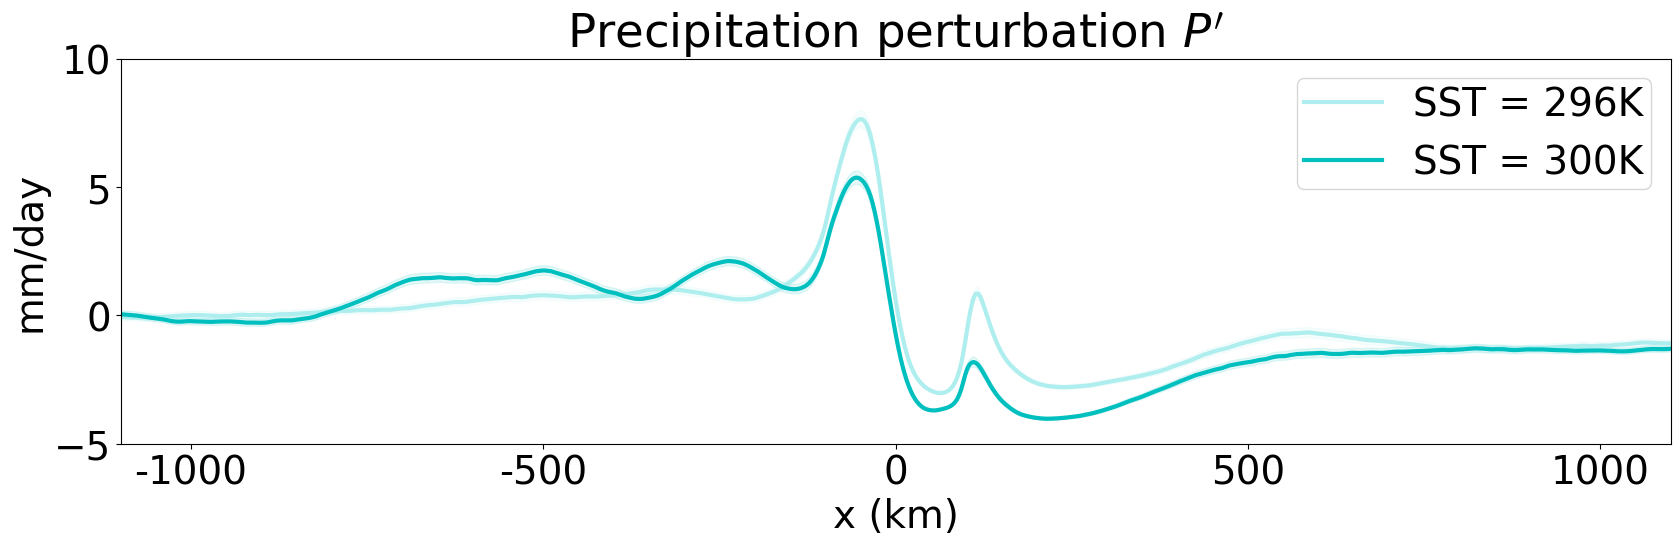

In [22]:
matplotlib.rcParams.update({'font.size': 28})
fig,ax2=plt.subplots(1,1,figsize=(20,5))


ticks = np.arange(-1000,1100,500)

for Sim in (W10S296,W10S300):
    prime(Sim.RAINNC_MEAN).plot(ax=ax2,color=Sim.color,label=Sim.label,linewidth=3)
    ax2.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)

ax2.set_ylim(-5,10)
ax2.set_ylabel("mm/day")
ax2.set_xlim(-1100,1100)
ax2.set_xticks(list(ticks))
ax2.set_xticklabels(ticks)
ax2.set_xlabel('x (km)')

#yticks=np.arange(-40,41,20)
#ax2.set_yticks(yticks)
ax2.legend(loc=1,borderpad=0.2,fontsize=28)

ax2.set_title(r"Precipitation perturbation $P'$")



# Simulations - change in $\theta_{eB}$

In [85]:
def cumtrapz(A, dim):
    """Cumulative Simpson's rule (aka Tai's method)

    Notes
    -----
    Simpson rule is given by
        int f (x) = sum (f_i+f_i+1) dx / 2
    """
    x = A[dim]
    dx = x - x.shift(**{dim:1})
    dx = dx.fillna(0.0)
    return ((A.shift(**{dim:1}) + A)*dx/2.0)\
          .fillna(0.0)\
          .cumsum(dim)
def upstream_mean(ds):
    return ds.sel(distance_from_mtn=slice(-2500,-4000)).mean('distance_from_mtn')
def integ_dx(integrand):
    integrand = integrand.reindex(distance_from_mtn=list(reversed(integrand.distance_from_mtn)))
    integrand = integrand.sel(pressure=925.)
    return prime(cumtrapz(integrand,'distance_from_mtn') * 1e3,True)
for Sim in (W10S300,W12S300):
    # Calculate Q_q diagnostically
    Sim.THETAE_MEAN = xr.open_dataarray(Sim.path+'wrf.THETAE.ALLMEAN.nc')
    Sim.U_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.U_PL.ALLMEAN.nc')
    Sim.OMEGA_PL_MEAN = -Sim.T_PL_MEAN.pressure*100/(287. * Sim.T_PL_MEAN) * 9.81 * Sim.W_PL_MEAN
    udthetaedx = -(Sim.U_PL_MEAN*Sim.THETAE_MEAN.differentiate('distance_from_mtn')/1000 * 86400)
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*Sim.THETAE_MEAN.differentiate('pressure')/100 * 86400)
    Qthetae = udthetaedx+omegadthetaedp
    Sim.OMEGADTHETAEDP = omegadthetaedp
    Sim.OMEGADTHETAE0DP = (Sim.OMEGA_PL_MEAN*upstream_mean(Sim.THETAE_MEAN).differentiate('pressure')/100 * 86400)
    Sim.QTHETAE = Qthetae
    

(-1100.0, 1100.0)

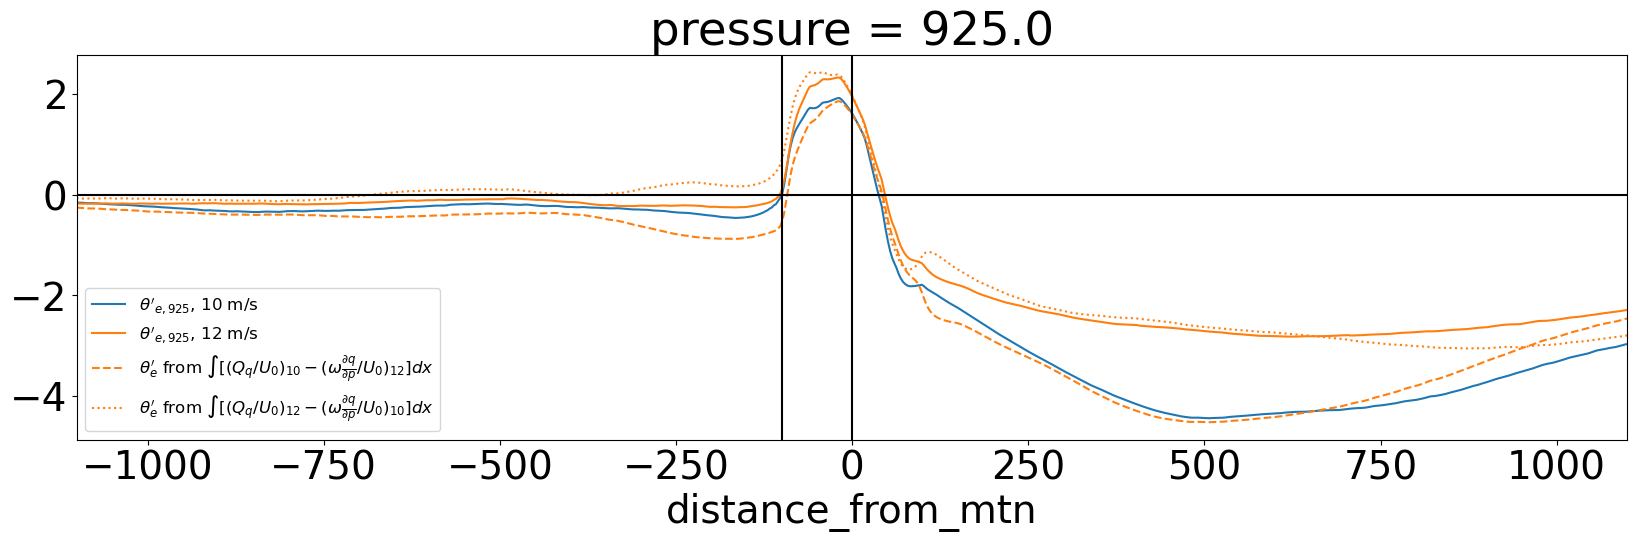

In [106]:
_,ax = plt.subplots(1,1,figsize=(20,5))
(prime(W10S300.THETAE_MEAN.sel(pressure=925))).plot(ax=ax,label = r"$\theta'_{e,925}$, 10 m/s")
(prime(W12S300.THETAE_MEAN.sel(pressure=925))).plot(ax=ax,label = r"$\theta'_{e,925}$, 12 m/s")

integrand = (W10S300.QTHETAE/(-W10S300.U_PL_MEAN)- W12S300.OMEGADTHETAEDP/(-W12S300.U_PL_MEAN))/86400
integ_dx(integrand).plot(ax=ax,color='C1',linestyle='--',label = r"$\theta_e'$ from $\int [(Q_q/U_0)_{10} - (\omega \frac{\partial q}{\partial p} / U_0)_{12}] dx$")

integrand = (W12S300.QTHETAE/(-W12S300.U_PL_MEAN)- W10S300.OMEGADTHETAEDP/(-W10S300.U_PL_MEAN))/86400
integ_dx(integrand).plot(ax=ax,color='C1',linestyle=':',label = r"$\theta_e'$ from $\int [(Q_q/U_0)_{12} - (\omega \frac{\partial q}{\partial p} / U_0)_{10}] dx$")

ax.legend(fontsize=12)
ax.axhline(0.,color='k')
ax.axvline(-100.,color='k')
ax.axvline(0.,color='k')
ax.set_xlim(-1100,1100)

(-1100.0, 1100.0)

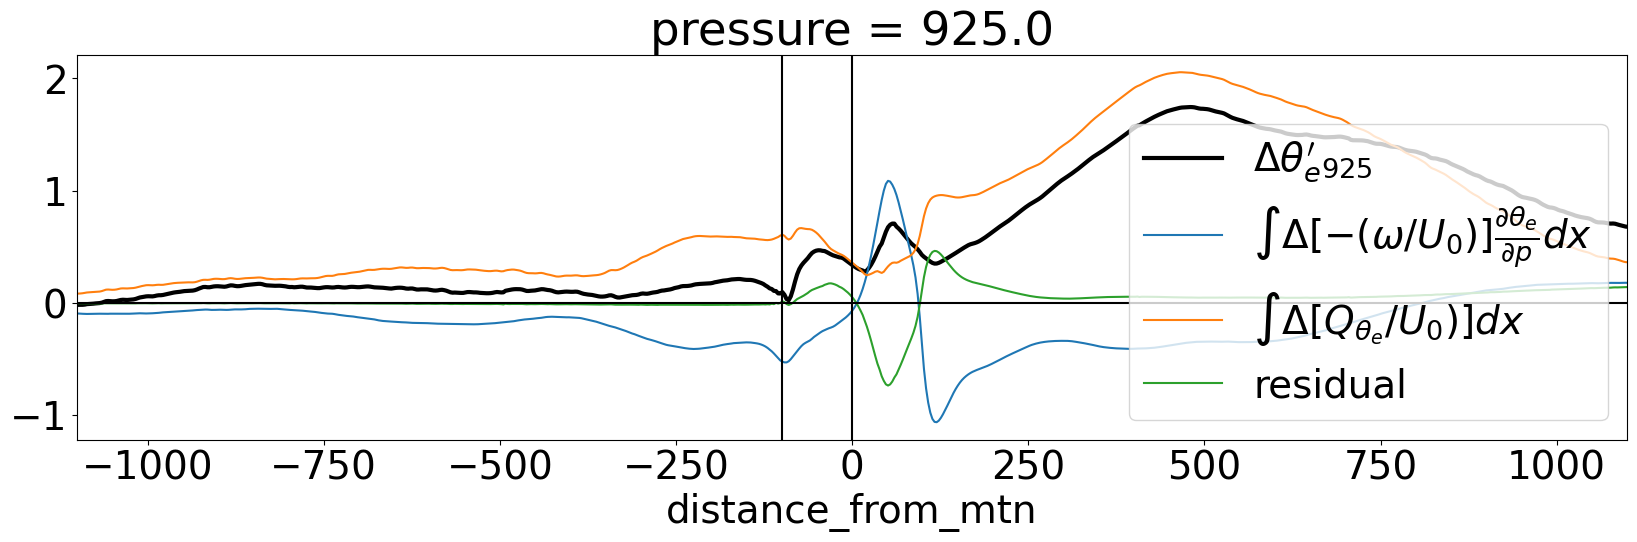

In [105]:
_,ax = plt.subplots(1,1,figsize=(20,5))
Delta0 = (prime(W12S300.THETAE_MEAN.sel(pressure=925)) - prime(W10S300 .THETAE_MEAN.sel(pressure=925)))
Delta0.plot(ax=ax,label = r"$\Delta \theta_e'_{925}$",color='k',linewidth=3)



dthetae0dp = upstream_mean(W10S300.THETAE_MEAN.differentiate('pressure'))/100
integrand = (- W10S300.OMEGA_PL_MEAN * dthetae0dp)/10
qprime10 = integ_dx(integrand)
integrand = (- W12S300.OMEGA_PL_MEAN * dthetae0dp)/12
qprime12 = integ_dx(integrand)
Delta1 = (qprime12-qprime10)
Delta1.plot(ax=ax,label = r"$\int \Delta[ - (\omega / U_0)] \frac{\partial \theta_e}{\partial p} dx$")

integrand = (W10S300.QTHETAE/86400)/10
qprime10 = integ_dx(integrand)
integrand = (W12S300.QTHETAE/86400)/12
qprime12 = integ_dx(integrand)
Delta2 = (qprime12-qprime10)
Delta2.plot(ax=ax,label = r"$\int \Delta[ Q_{\theta_e} / U_0)] dx$")

(Delta0 - Delta1 -Delta2).plot(ax=ax,label = r"residual")
#Sim = W10S300
#integrand = (Sim.QTHETAE- Sim.OMEGADTHETAEDP*0)/86400/10
#qprime10 = integ_dx(integrand)
#Sim = W12S300
#integrand = (Sim.QTHETAE- Sim.OMEGADTHETAEDP*0)/86400/12
#qprime12 = integ_dx(integrand)
#
#(qprime12-qprime10).plot(ax=ax,label = r"$\Delta \theta_e'$ from $\int [ (Q_{\theta_e} / U_0)] dx$")
#
#
#
#integrand = (W10S300.QTHETAE- Sim.OMEGADTHETAEDP*0)/86400/10
#qprime10 = integ_dx(integrand)
#integrand = (W10S300.QTHETAE- Sim.OMEGADTHETAEDP*0)/86400/12
#qprime12 = integ_dx(integrand)
#
#(qprime12-qprime10).plot(ax=ax,label = r"$\Delta \theta_e'$ from $\int [ (Q_{\theta_e,fixed} / U_0)] dx$",color='C3',linestyle='--')





ax.legend()
ax.axhline(0.,color='k')
ax.axvline(-100.,color='k')
ax.axvline(0.,color='k')
ax.set_xlim(-1100,1100)

(-1100.0, 1100.0)

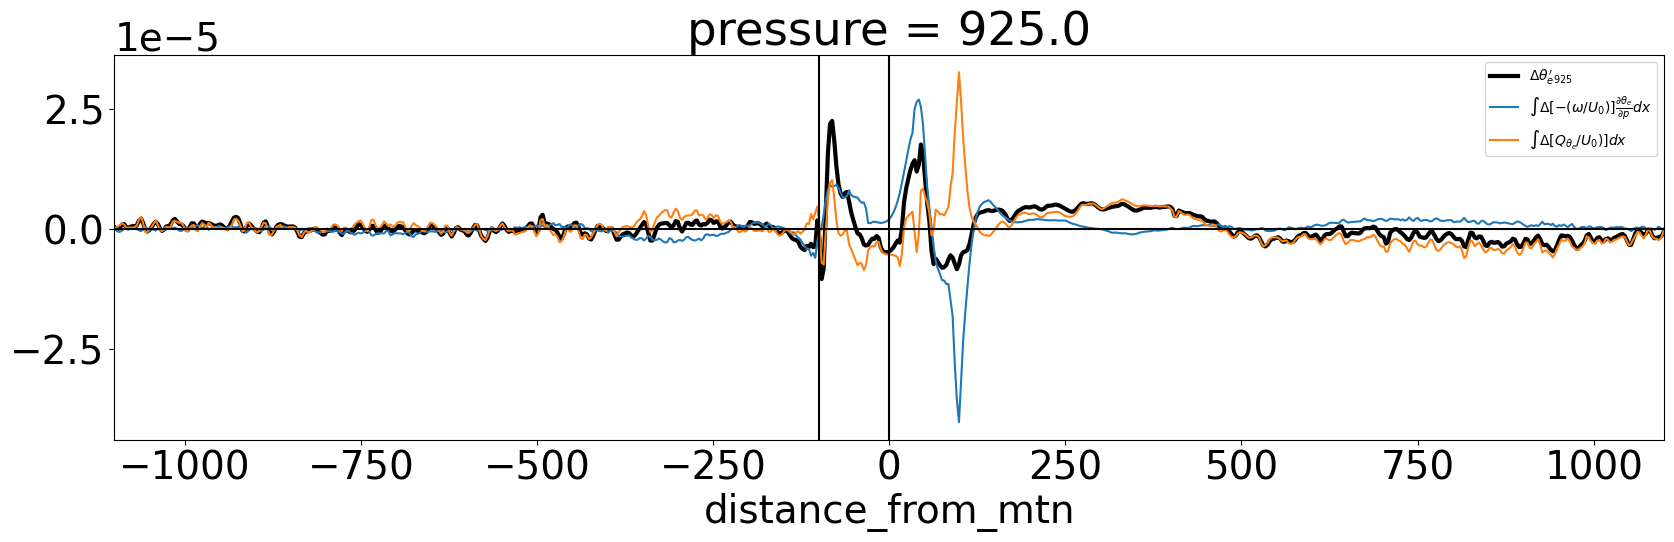

In [111]:
_,ax = plt.subplots(1,1,figsize=(20,5))
Delta0 = (W12S300.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3 
         -W10S300.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3
         )
Delta0.plot(ax=ax,label = r"$\Delta \theta_e'_{925}$",color='k',linewidth=3)


integrand10 = (- W10S300.OMEGADTHETAEDP/86400)/10
integrand12 = (- W12S300.OMEGADTHETAEDP/86400)/12
Delta1 = (integrand12-integrand10).sel(pressure=925)
Delta1.plot(ax=ax,label = r"$\int \Delta[ - (\omega / U_0)] \frac{\partial \theta_e}{\partial p} dx$")

integrand10 = (W10S300.QTHETAE/86400)/10
integrand12 = (W12S300.QTHETAE/86400)/12
Delta2 = (integrand12-integrand10).sel(pressure=925)
Delta2.plot(ax=ax,label = r"$\int \Delta[ Q_{\theta_e} / U_0)] dx$")


ax.legend(fontsize=10)
ax.axhline(0.,color='k')
ax.axvline(-100.,color='k')
ax.axvline(0.,color='k')
ax.set_xlim(-1100,1100)

(-1100.0, 1100.0)

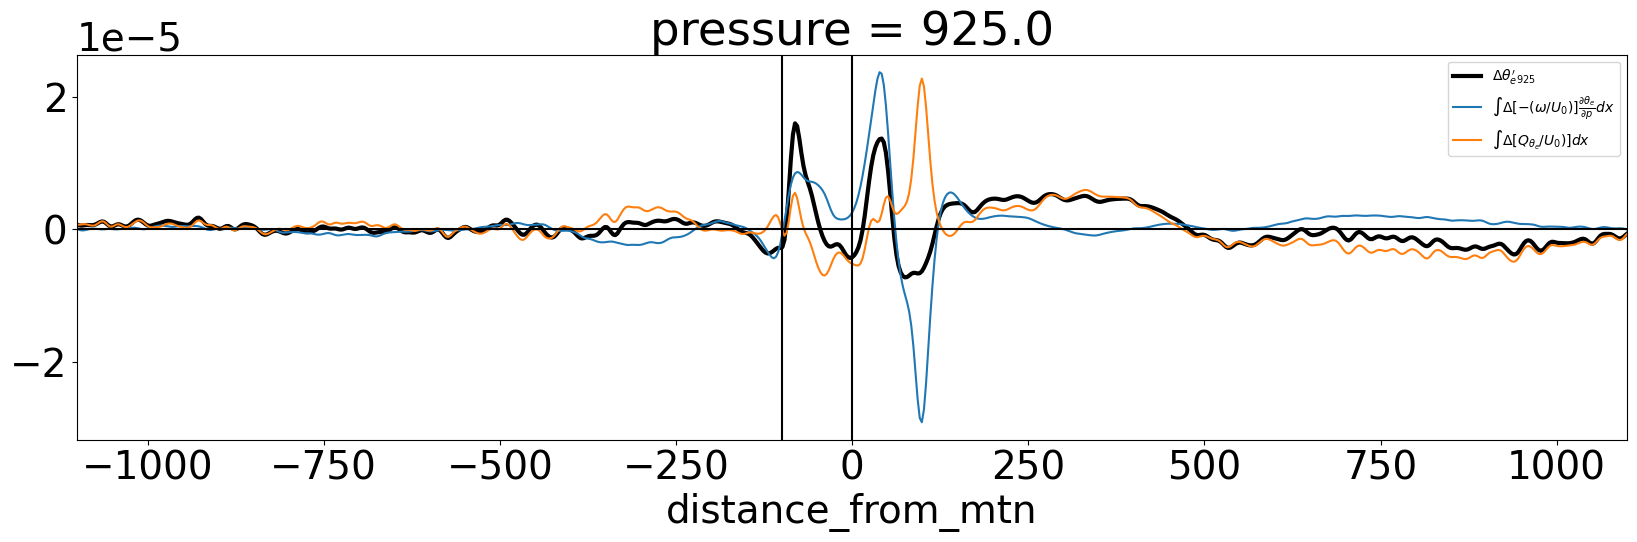

In [119]:
from scipy.ndimage import gaussian_filter
def smooth(ds):
    return xr.apply_ufunc(gaussian_filter,ds,kwargs={"sigma":2.})

_,ax = plt.subplots(1,1,figsize=(20,5))
Delta0 = (W12S300.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3 
         -W10S300.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3
         )
smooth(Delta0).plot(ax=ax,label = r"$\Delta \theta_e'_{925}$",color='k',linewidth=3)


integrand10 = (- W10S300.OMEGADTHETAEDP/86400)/10
integrand12 = (- W12S300.OMEGADTHETAEDP/86400)/12
Delta1 = (integrand12-integrand10).sel(pressure=925)
smooth(Delta1).plot(ax=ax,label = r"$\int \Delta[ - (\omega / U_0)] \frac{\partial \theta_e}{\partial p} dx$")

integrand10 = (W10S300.QTHETAE/86400)/10
integrand12 = (W12S300.QTHETAE/86400)/12
Delta2 = (integrand12-integrand10).sel(pressure=925)
smooth(Delta2).plot(ax=ax,label = r"$\int \Delta[ Q_{\theta_e} / U_0)] dx$")


#dthetae0dp = upstream_mean(W10S300.THETAE_MEAN.differentiate('pressure'))/100
#dpdz = 9.81 * W10S300.T_PL_MEAN.pressure*100/287./upstream_mean(W10S300.T_PL_MEAN)
#dthetae0dz = dthetae0dp * dpdz
#((w_linear_12/12-w_linear_10/10).sel(pressure=925,method='nearest')*dthetae0dz.sel(pressure=925)).plot(label = r"lin.theory")


ax.legend(fontsize=10)
ax.axhline(0.,color='k')
ax.axvline(-100.,color='k')
ax.axvline(0.,color='k')
ax.set_xlim(-1100,1100)

In [114]:
from orographicPrecipitation.observationsAndERA5.linearWaveModels import second_derivative_matrix, linear_w_1layer,linear_w_generalized, linear_w_generalized_forced, w_to_Tprime,w_to_qprime,z_to_p_standard
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile,k_vector

z=np.linspace(0,20e3,200)
xx ,hx = topographic_profile('cos',A=500)
xx = xx[1000:3001]
hx = hx[1000:3001]
w_linear_10 = linear_w_1layer(xx,hx,z,10,0.01)
w_linear_12 = linear_w_1layer(xx,hx,z,12,0.01)

p = z_to_p_standard(w_linear_10.altitude*1000)
w_linear_10 = w_linear_10.assign_coords({'pressure':p}).swap_dims({'altitude':'pressure'})
w_linear_12 = w_linear_12.assign_coords({'pressure':p}).swap_dims({'altitude':'pressure'})

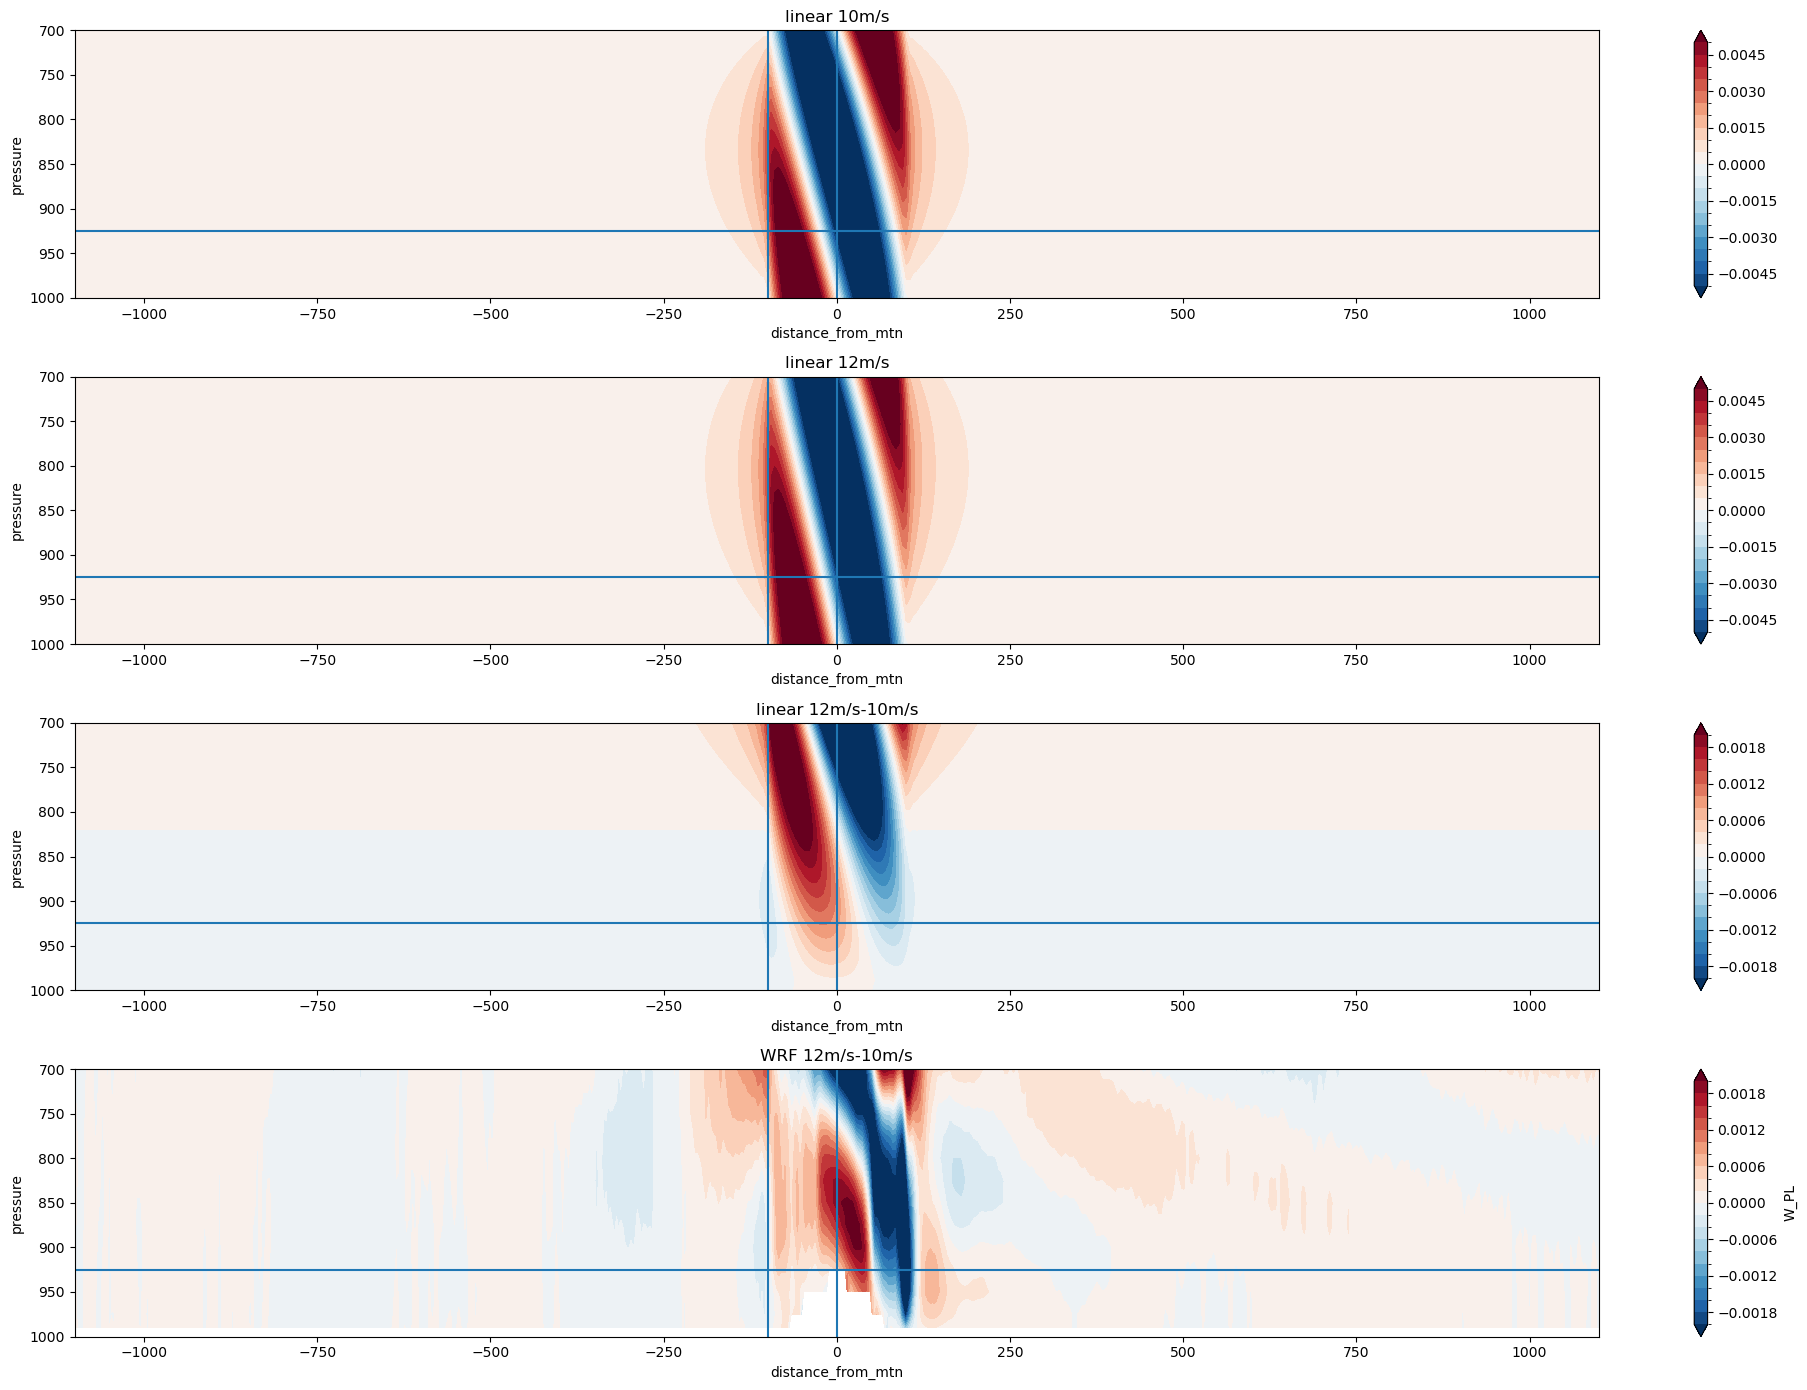

In [114]:
fig,axs = plt.subplots(4,1,figsize=(20,14))

M=0.005
(w_linear_10/10).plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=np.linspace(-M,M,21),extend='both')
(w_linear_12/12).plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=np.linspace(-M,M,21),extend='both')
M=0.002
(w_linear_12/12-w_linear_10/10).plot.contourf(ax=axs[2],y='pressure',yincrease=False,levels=np.linspace(-M,M,21),extend='both')
(W12S300n .W_PL_MEAN/12-W10S300n2.W_PL_MEAN/10).plot.contourf(ax=axs[3],y='pressure',yincrease=False,levels=np.linspace(-M,M,21),extend='both')

axs[0].set_title('linear 10m/s')
axs[1].set_title('linear 12m/s')
axs[2].set_title('linear 12m/s-10m/s')
axs[3].set_title('WRF 12m/s-10m/s')
for ax in axs:
    ax.set_xlim(-1100,1100)
    ax.set_ylim(1000,700)
    ax.axhline(925)
    ax.axvline(-100)
    ax.axvline(0)
fig.tight_layout()

# Simulations - W dq/dz vs P'

In [31]:
import dask
from dask.distributed import Client, LocalCluster
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
client = Client(n_workers=8,threads_per_worker=4,memory_limit='10G')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:8787/status,
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34211,Workers: 8
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:41899,Total threads: 4
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:37265/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:42875,


In [54]:
for Sim in W10S300,W12S300:
    sfcvars = xr.open_zarr(Sim.path + "wrf.SFCVARS.1h.%s.zarr"%Sim.suffix2)
    Sim.U10_MEAN = sfcvars.U10[1200:].mean(('Time','south_north')).load()
    Sim.Q2_MEAN  = sfcvars.Q2[1200:].mean(('Time','south_north')).load()
    
    psfc = xr.open_zarr(Sim.path + "wrf.PSFC_INTERP.1h.%s.zarr"%Sim.suffix2)
    Sim.PSFC_MEAN = psfc.PSFC[-100:].mean(('Time','south_north')).load()

In [16]:
for Sim in W10S300,W12S300:
    Sim.RHO_PL_MEAN = (Sim.T_PL_MEAN.pressure*100./287./Sim.T_PL_MEAN)
    Sim.OMEGA_PL_MEAN = (-Sim.RHO_PL_MEAN*9.81*Sim.W_PL_MEAN)
        

In [91]:
def integrate_wsfc(a,asfc,psfc,pname='pressure',pfact=100):
    valid_idx = np.isnan(a).argmin(dim=pname)
    integ_a = a.fillna(0.).integrate(pname)*pfact

    valid_val = a.isel(pressure=valid_idx)
    valid_p = pfact * a[pname].isel(pressure=valid_idx)
    belowsfc_p = pfact * a[pname].isel(pressure=np.maximum(0,valid_idx-1))
    correction = (valid_idx>0) * valid_val * (valid_p - belowsfc_p) / 2
    
    sfc_term = (asfc + valid_val)/2 * (psfc - valid_p)
    return integ_a - correction + sfc_term

In [106]:
for Sim in W10S300,W12S300:
    Sim.wdqdp = Sim.OMEGA_PL_MEAN*Sim.Q_PL_MEAN.differentiate('pressure')/100 * 86400
    Sim.wdqdp_integ_dumb = Sim.wdqdp.fillna(0.).integrate('pressure')*100/9.81
    
    w_sfc = Sim.U10_MEAN * Sim.PSFC_MEAN.differentiate('distance_from_mtn')/1e3
    
    #constant estimate
    dqdp_sfc = (Sim.Q_PL_MEAN.isel(pressure=0) - Sim.Q2_MEAN)/(100*Sim.Q_PL_MEAN.pressure.isel(pressure=0) - Sim.PSFC_MEAN)
    dqdp_sfc = dqdp_sfc.sel(distance_from_mtn = slice(-2500,-4000)).mean('distance_from_mtn')
    Sim.wdqdp_sfc = w_sfc * dqdp_sfc * 86400
    Sim.wdqdp_integ = integrate_wsfc(Sim.wdqdp, Sim.wdqdp_sfc, Sim.PSFC_MEAN)/9.81


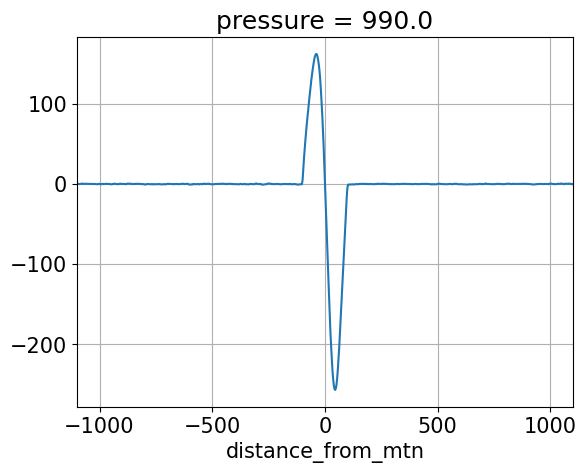

In [104]:
(2.5e3*W10S300.wdqdp_sfc).plot()
plt.xlim(-1100,1100)
plt.grid()

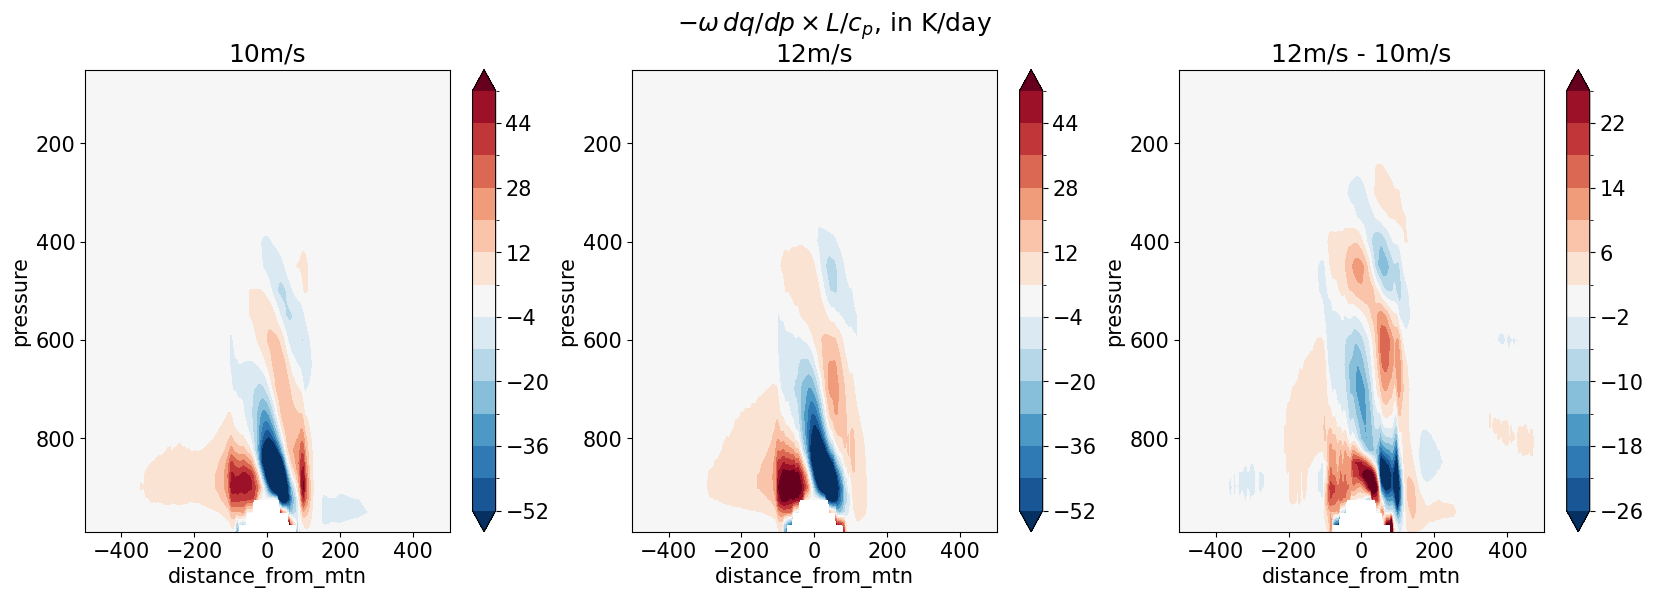

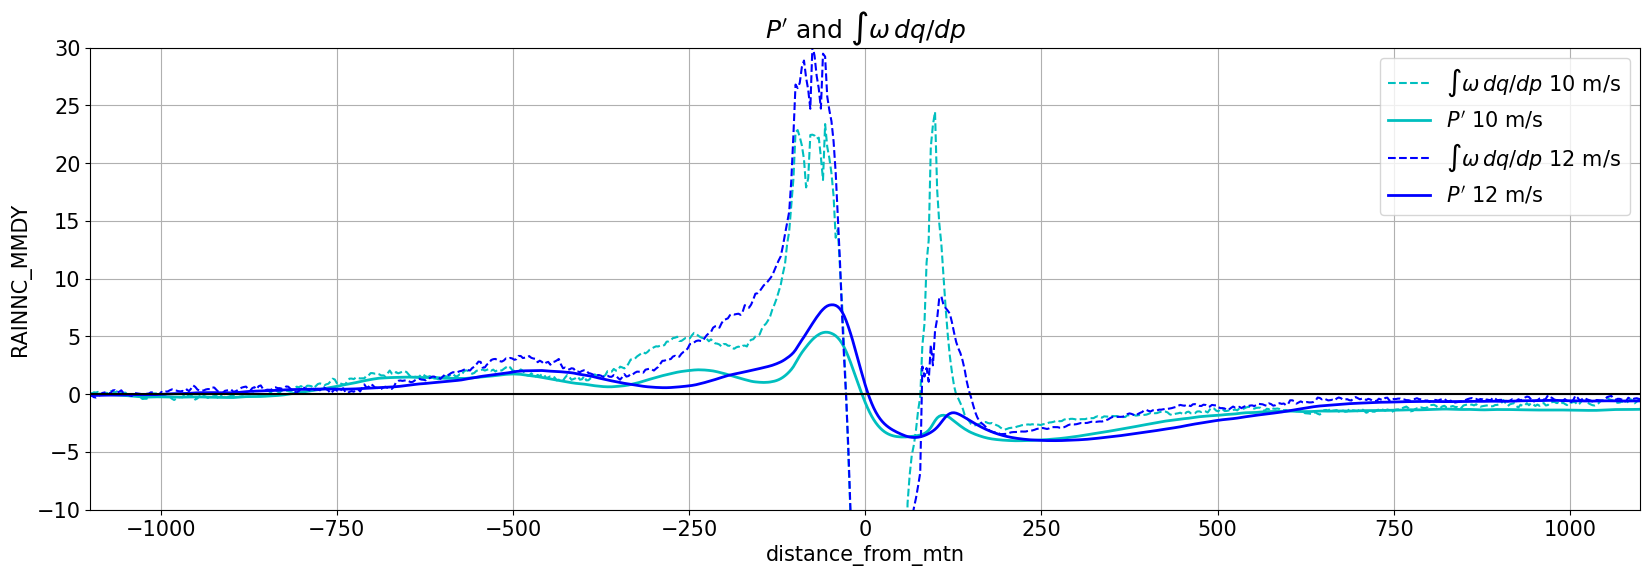

In [108]:
fig,axs=plt.subplots(1,3,figsize=(20,6))
for W,ax,ttl,levs in zip((W10S300.wdqdp,W12S300.wdqdp,W12S300.wdqdp-W10S300.wdqdp),axs,(r'10m/s',r'12m/s',r'12m/s - 10m/s'),(np.arange(-4-8*6,5+8*6,8),np.arange(-4-8*6,5+8*6,8),np.arange(-2-4*6,3+4*6,4))):
    (-2.5e3*W).plot.contourf(ax=ax,y='pressure',yincrease=False,cmap=plt.cm.RdBu_r,levels=levs,extend='both')
    ax.set_xlim(-500,500)
    ax.set_title(ttl)
fig.suptitle(r"$- \omega\,dq/dp \times L/c_p$, in K/day")

_,ax=plt.subplots(1,1,figsize=(20,6))
for Sim,ttl in zip((W10S300,W12S300),(r'10 m/s',r'12 m/s')):
    Sim.wdqdp_integ.plot(ax=ax,color=Sim.color,linestyle='--',label=r'$\int \omega\,dq/dp$ '+ttl)
    #Sim.wdqdp_integ.plot(ax=ax,color=Sim.color,linestyle=':')
    (prime(Sim.RAINNC_MEAN)).plot(ax=ax,color=Sim.color,label=r"$P'$ " + ttl,linewidth=2)
ax.set_xlim(-1100,1100)
ax.set_ylim(-10,30)
ax.grid()
ax.set_title("$P'$ and $\int \omega\,dq/dp$")
ax.legend()
ax.axhline(0.,color='k')